<a href="https://colab.research.google.com/github/iamnotvk/AppliedML_Assignment3/blob/main/Term_Project_Part_2_(Final).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install sklearn-som

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,StackingClassifier
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.naive_bayes import GaussianNB
from sklearn.base import clone
from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten
import numpy as np
from sklearn.neural_network import MLPClassifier
from tqdm.auto import tqdm
import sys
import pickle
from sklearn_som.som import SOM
from sklearn.feature_selection import SequentialFeatureSelector
from tqdm.auto import tqdm

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
rs = 0
link = "https://github.com/iamnotvk/TermProjectAppliedML/raw/main/MCSDatasetNEXTCONLab.csv"
df = pd.read_csv(link)
df['Ligitimacy'] = df['Ligitimacy'].replace(0,-1)
trDf = df[:10139][:]
teDf = df[10139:][:]
trDf = trDf.apply(lambda x: (x-45)*10000 if x.name == 'Latitude' else x)
trDf = trDf.apply(lambda x: (x+75)*10000 if x.name == 'Longitude' else x)
teDf = teDf.apply(lambda x: (x-45)*10000 if x.name == 'Latitude' else x)
teDf = teDf.apply(lambda x: (x+75)*10000 if x.name == 'Longitude' else x)
trY = trDf['Ligitimacy'].values
teY = teDf['Ligitimacy'].values
trX = trDf.drop(columns=['ID', 'Day', 'Ligitimacy']).values
teX = teDf.drop(columns=['ID', 'Day', 'Ligitimacy']).values

In [ ]:
scaler = StandardScaler()
trX = scaler.fit_transform(trX)
teX = scaler.transform(teX)

In [ ]:
def get_accuracy(lr,momentum):
    tmp_acc_list=[]
    for _ in range(10):
        clf = MLPClassifier(activation="tanh", solver='sgd', hidden_layer_sizes=(15,15),learning_rate="constant",learning_rate_init=lr,momentum=momentum)
        clf.fit(trX,trY)
        yPred = clf.predict(teX)
        tmp_acc_list.append(round(accuracy_score(teY,yPred)*100,2))
    acc = round((sum(tmp_acc_list) / len(tmp_acc_list)))   
    return acc

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
lr_min = 0.01
mom_min = 0.01
best_acc = 0
for lr in tqdm(np.arange(0.01,0.11,0.01)):
    for momentum in tqdm(np.arange(0.9,1.01,0.01)):
        current = get_accuracy(lr,momentum)
        if(current>best_acc):
            best_acc = current
            lr_min = lr 
            mom_min = momentum
print(lr_min,mom_min,best_acc)

Accuracy | MLP Classifier 92.52%


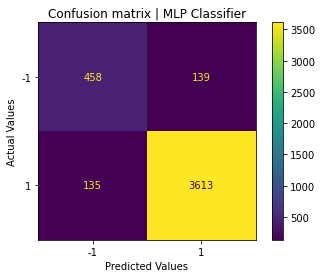

In [ ]:
import warnings
warnings.filterwarnings("ignore")
lr=0.01
momentum=0.97
accuracy = []
filename = 'finalmodel.sav'
for i in range(10):
    clf = MLPClassifier(activation="tanh", solver='sgd', hidden_layer_sizes=(15,15),learning_rate="constant",learning_rate_init=lr,momentum=momentum)
    clf.fit(trX,trY)
    yPred = clf.predict(teX)
    accuracy.append(round(accuracy_score(teY,yPred)*100,2))
    if(i!=0):
        if(accuracy[i]>accuracy[i-1]):
            pickle.dump(clf,open(filename,'wb'))
    else:
        pickle.dump(clf,open(filename,'wb'))
acc = round((sum(accuracy) / len(accuracy)),2)
print("Accuracy | MLP Classifier {}%".format(acc))
clf = pickle.load(open(filename, 'rb'))
plot_confusion_matrix(clf,teX,teY)
plt.title('Confusion matrix | MLP Classifier')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
def select_feature(X_TR, y_TR, X_TS, y_TS, FSM, MODEL):
    fs = FSM
    fs.fit(X_TR, y_TR)
    X_TR_new = fs.transform(X_TR)
    X_TS_new = fs.transform(X_TS)
    MODEL.fit(X_TR_new, y_TR)
    yPred = MODEL.predict(X_TS_new)
    acc = round(accuracy_score(y_TS, yPred) * 100,2)
    return acc

In [ ]:
model = clf
accuracy_dict = {}
for i in tqdm(range(1,trX.shape[1])): 
  sfs = SequentialFeatureSelector(model, n_features_to_select=i)
  acc = select_feature(trX, trY, teX, teY, sfs, model)
  accuracy_dict[i] = acc


  0%|          | 0/9 [00:00<?, ?it/s]

Maximum accuracy: 98.0
Best number of features: 2


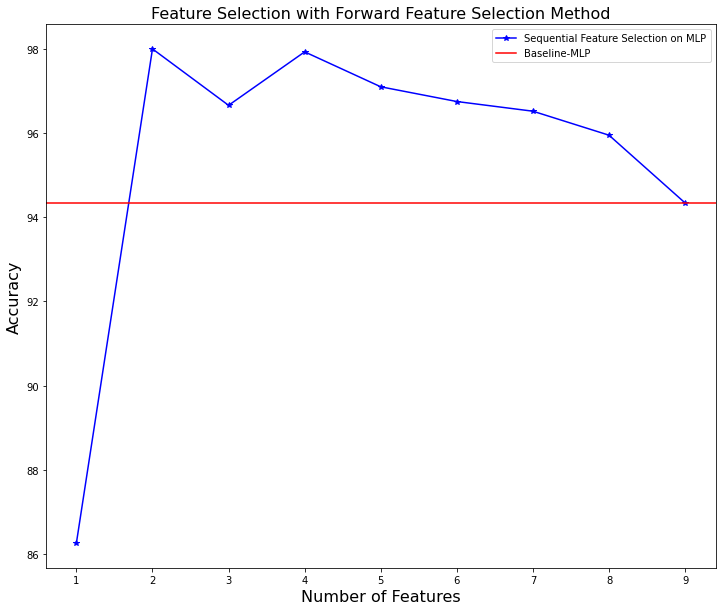

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(*zip(*sorted(accuracy_dict.items())),color='blue',marker='*')
plt.axhline(y=acc, color= "red")
Title = "Feature Selection with Forward Feature Selection Method"
plt.title(Title, fontsize=16)
plt.xticks(range(1,trX.shape[1]))
plt.xlabel("Number of Features", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.legend(["Sequential Feature Selection on MLP","Baseline-MLP"])
accuracy_mlp = max(accuracy_dict.values())
nf_mlp =  max(accuracy_dict, key=accuracy_dict.get)
print("Maximum accuracy:", accuracy_mlp)
print("Best number of features:", nf_mlp)

In [ ]:
model = clf
sfs = SequentialFeatureSelector(model, n_features_to_select=nf_mlp)
sfs.fit(trX, trY)
mlp_trainX = sfs.transform(trX)
mlp_testX = sfs.transform(teX)
filename = 'finalmodel2.sav'
accuracy_score_nf=[]
for i in range(10):
    clf.fit(mlp_trainX,trY)
    yPred = clf.predict(mlp_testX)
    accuracy_score_nf.append(round(accuracy_score(teY,yPred)*100,2))
    if(i!=0):
        if(accuracy_score_nf[i]>accuracy_score_nf[i-1]):
            pickle.dump(clf,open(filename,'wb'))
    else:
        pickle.dump(clf,open(filename,'wb'))

Accuracy of the MLP Classifier Using Wrapper method: 97.41


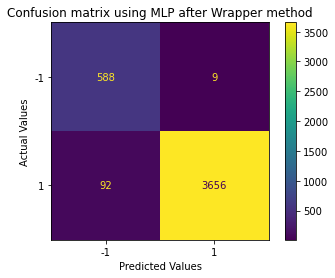

In [ ]:
clf = pickle.load(open(filename, 'rb'))
acc_score_nf = round(sum(accuracy_score_nf) / len(accuracy_score_nf),2)
print("Accuracy of the MLP Classifier Using Wrapper method:", acc_score_nf )
plot_confusion_matrix(clf,mlp_testX,teY)
plt.title('Confusion matrix using MLP after Wrapper method')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
clf = pickle.load(open(filename, 'rb'))
accuracy_score_cls = {}
for k in tqdm(range(2,9)):
    dummy,dimension = mlp_trainX.shape
    som = SOM(m=k,n=k,dim=dimension,random_state=0)
    trcluster = som.fit_predict(mlp_trainX)
    tecluster = som.predict(mlp_testX)
    som_trainX = np.append(mlp_trainX,trcluster.reshape(-1,1),axis=1)
    som_testX = np.append(mlp_testX,tecluster.reshape(-1,1),axis=1)
    accuracy_best_cluster=[]
    for i in range(10):
        clf.fit(som_trainX,trY)
        yPred = clf.predict(som_testX)
        accuracy_best_cluster.append(round(accuracy_score(teY,yPred)*100,2))
    accuracy_score_cls[k] = round(sum(accuracy_best_cluster)/len(accuracy_best_cluster),2)

  0%|          | 0/7 [00:00<?, ?it/s]

Maximum accuracy: 97.89
Best value of K: 2


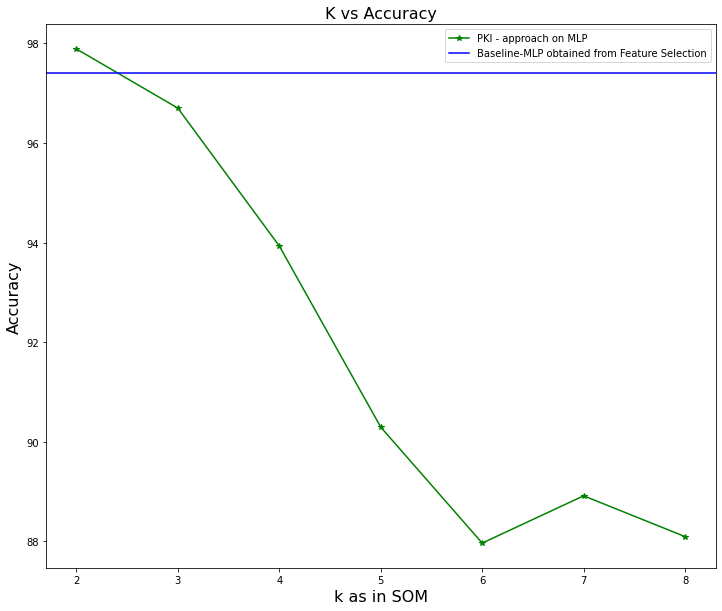

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(*zip(*sorted(accuracy_score_cls.items())),color='green',marker='*')
plt.axhline(y=acc_score_nf, color= "blue")
Title = "K vs Accuracy"
plt.title(Title, fontsize=16)
plt.xticks(range(2,9))
plt.xlabel("k as in SOM", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.legend(["PKI - approach on MLP","Baseline-MLP obtained from Feature Selection"])
acc_b_mlp = max(accuracy_score_cls.values())
b_mlp =  max(accuracy_score_cls, key=accuracy_score_cls.get)
print("Maximum accuracy:", acc_b_mlp)
print("Best value of K:", b_mlp)

In [ ]:
clf = pickle.load(open(filename, 'rb'))
k = b_mlp
dummy ,dimension =mlp_trainX.shape
som = SOM(m=k,n=k,dim=dimension,random_state=0)
trcluster = som.fit_predict(mlp_trainX)
tecluster = som.predict(mlp_testX)
som_trainX = np.append(mlp_trainX,trcluster.reshape(-1,1),axis=1)
som_testX = np.append(mlp_testX,tecluster.reshape(-1,1),axis=1)
filename = 'finalmodel3.sav'
accuracy_best_cluster = []
for i in range(10):
    clf.fit(som_trainX,trY)
    yPred = clf.predict(som_testX)
    accuracy_best_cluster.append(round(accuracy_score(teY,yPred)*100,2))
    if(i!=0):
        if(accuracy_best_cluster[i]>accuracy_best_cluster[i-1]):
            pickle.dump(clf,open(filename,'wb'))
    else:
        pickle.dump(clf,open(filename,'wb'))

Accuracy of the MLP Classifier using PKI Approach is 98.21


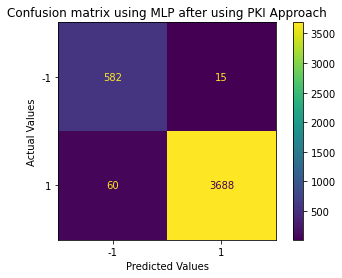

In [ ]:
clf = pickle.load(open(filename, 'rb'))
acc_nf = round((sum(accuracy_best_cluster) / len(accuracy_best_cluster)),2)
print("Accuracy of the MLP Classifier using PKI Approach is",acc_nf)
plot_confusion_matrix(clf,som_testX,teY)
plt.title('Confusion matrix using MLP after using PKI Approach')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [ ]:
combined_dictionary={}
cnt=0
for i in range(3,11): #i = Hidden Layer
    for j in range (10,31): #j = Neural Number
        arr=[]
        for i in range(1,i+1):
            arr.append(j)
        cnt = cnt+1
        combined_dictionary[cnt] = tuple(arr)

In [ ]:
print(combined_dictionary)

{1: (10, 10, 10), 2: (11, 11, 11), 3: (12, 12, 12), 4: (13, 13, 13), 5: (14, 14, 14), 6: (15, 15, 15), 7: (16, 16, 16), 8: (17, 17, 17), 9: (18, 18, 18), 10: (19, 19, 19), 11: (20, 20, 20), 12: (21, 21, 21), 13: (22, 22, 22), 14: (23, 23, 23), 15: (24, 24, 24), 16: (25, 25, 25), 17: (26, 26, 26), 18: (27, 27, 27), 19: (28, 28, 28), 20: (29, 29, 29), 21: (30, 30, 30), 22: (10, 10, 10, 10), 23: (11, 11, 11, 11), 24: (12, 12, 12, 12), 25: (13, 13, 13, 13), 26: (14, 14, 14, 14), 27: (15, 15, 15, 15), 28: (16, 16, 16, 16), 29: (17, 17, 17, 17), 30: (18, 18, 18, 18), 31: (19, 19, 19, 19), 32: (20, 20, 20, 20), 33: (21, 21, 21, 21), 34: (22, 22, 22, 22), 35: (23, 23, 23, 23), 36: (24, 24, 24, 24), 37: (25, 25, 25, 25), 38: (26, 26, 26, 26), 39: (27, 27, 27, 27), 40: (28, 28, 28, 28), 41: (29, 29, 29, 29), 42: (30, 30, 30, 30), 43: (10, 10, 10, 10, 10), 44: (11, 11, 11, 11, 11), 45: (12, 12, 12, 12, 12), 46: (13, 13, 13, 13, 13), 47: (14, 14, 14, 14, 14), 48: (15, 15, 15, 15, 15), 49: (16, 16,

In [ ]:
accuracy_tuning = {}
for key in tqdm(range(1,106)):
    temp_acc = []
    for dummy in range(10):
        clf = MLPClassifier(activation="tanh", solver='sgd', hidden_layer_sizes=combined_dictionary[key],learning_rate="constant",learning_rate_init=lr,momentum=momentum)
        clf.fit(som_trainX,trY)
        yPred = clf.predict(som_testX)
        temp_acc.append(round(accuracy_score(teY,yPred)*100,2))
    accuracy_tuning[key] = round(sum(temp_acc)/len(temp_acc),2)


  0%|          | 0/99 [00:00<?, ?it/s]

In [ ]:
print(accuracy_tuning)

{1: 98.19, 2: 98.39, 3: 98.42, 4: 98.35, 5: 98.25, 6: 98.38, 7: 98.27, 8: 98.58, 9: 98.56, 10: 98.71, 11: 98.5, 12: 98.53, 13: 98.65, 14: 98.51, 15: 98.78, 16: 98.64, 17: 98.76, 18: 98.78, 19: 98.66, 20: 98.61, 21: 98.59, 22: 98.16, 23: 98.16, 24: 98.36, 25: 98.37, 26: 98.64, 27: 98.43, 28: 98.21, 29: 98.29, 30: 98.42, 31: 98.54, 32: 98.54, 33: 98.64, 34: 98.32, 35: 98.44, 36: 98.34, 37: 98.5, 38: 98.71, 39: 98.62, 40: 98.47, 41: 98.7, 42: 98.65, 43: 97.98, 44: 98.22, 45: 98.29, 46: 98.28, 47: 98.49, 48: 98.29, 49: 98.06, 50: 98.53, 51: 98.55, 52: 98.45, 53: 98.19, 54: 98.48, 55: 98.52, 56: 98.6, 57: 98.59, 58: 98.57, 59: 98.42, 60: 98.43, 61: 98.52, 62: 98.49, 63: 98.68, 64: 97.66, 65: 97.76, 66: 97.73, 67: 97.94, 68: 98.14, 69: 98.16, 70: 98.58, 71: 98.36, 72: 98.3, 73: 98.19, 74: 98.51, 75: 97.73, 76: 98.55, 77: 98.43, 78: 98.43, 79: 98.43, 80: 98.35, 81: 98.43, 82: 98.36, 83: 98.39, 84: 98.73, 85: 95.94, 86: 95.77, 87: 97.76, 88: 96.75, 89: 98.44, 90: 97.51, 91: 98.07, 92: 97.75, 9

In [ ]:
accuracy_tuning_max = max(accuracy_tuning.values())
best_tuning_index =  max(accuracy_tuning, key=accuracy_tuning.get)
print("Maximum accuracy:", accuracy_tuning_max)
print("Index", best_tuning_index)
print("Number of Hidden Layers is {} and Number of Neurons is {}" .format(len(combined_dictionary[best_tuning_index]),combined_dictionary[best_tuning_index][0]))

Maximum accuracy: 98.78
Index 15


NameError: ignored